In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220725_VARprocess_EC_allsubjects_180.0s_segment_1200.0s_VARlength"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010074_EC    10
sub-010070_EC    10
sub-010072_EC    10
sub-010069_EC    10
sub-010073_EC    10
                 ..
sub-010059_EC    10
sub-010062_EC    10
sub-010060_EC    10
sub-010063_EC    10
sub-010064_EC    10
Length: 203, dtype: int64

10.0

9.89655172413793

<AxesSubplot:xlabel='order', ylabel='AIC'>

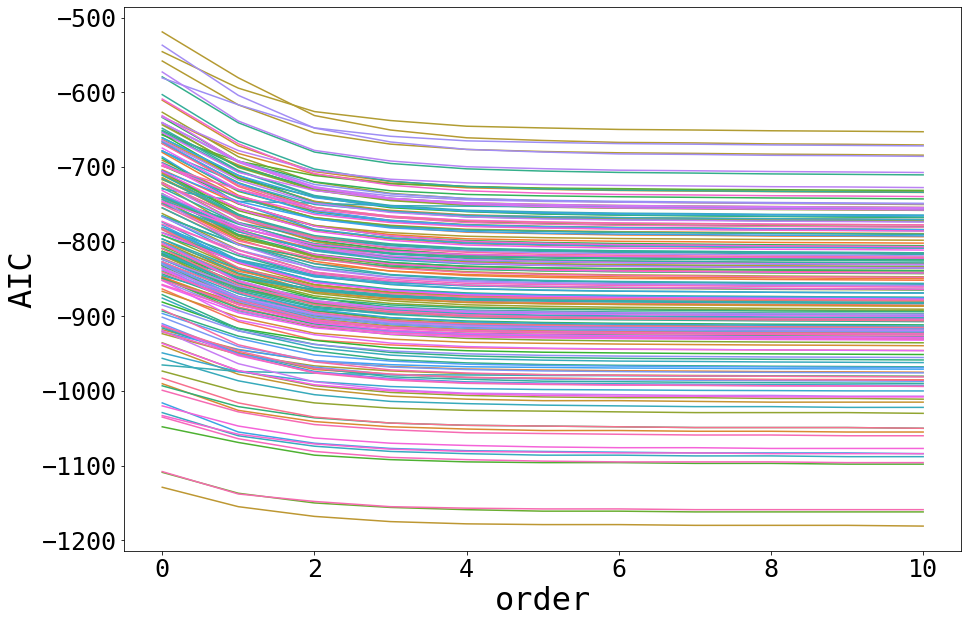

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_93551/2980343528.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_93551/2980343528.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


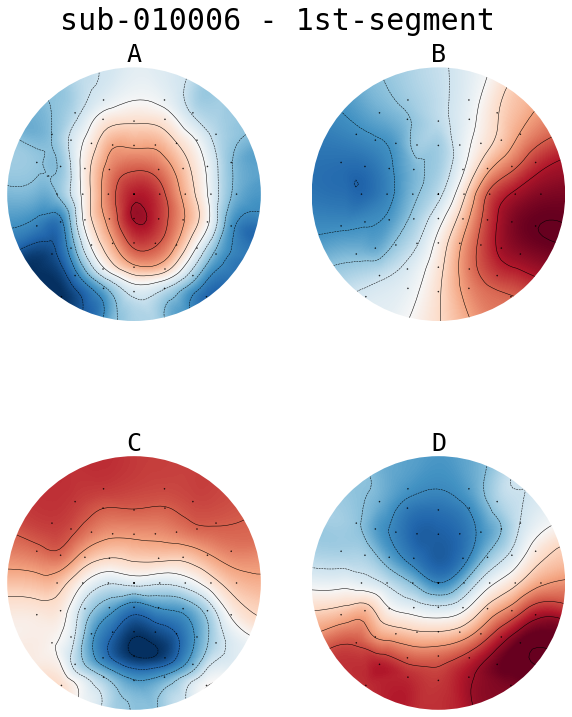

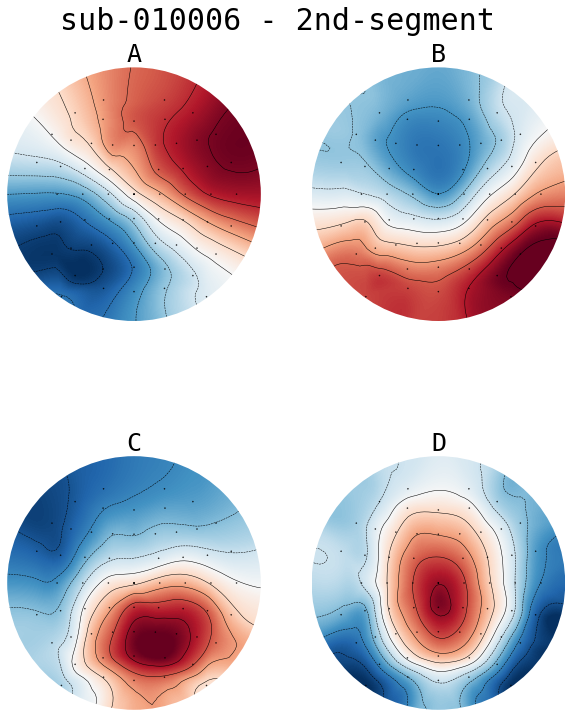

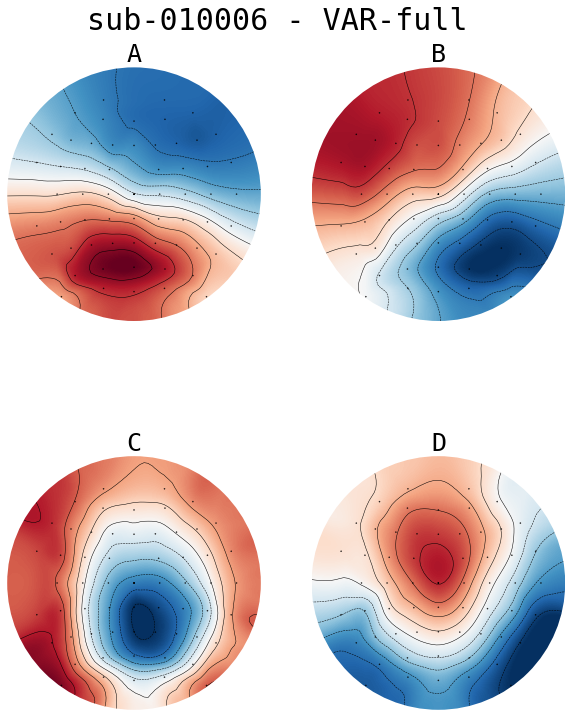

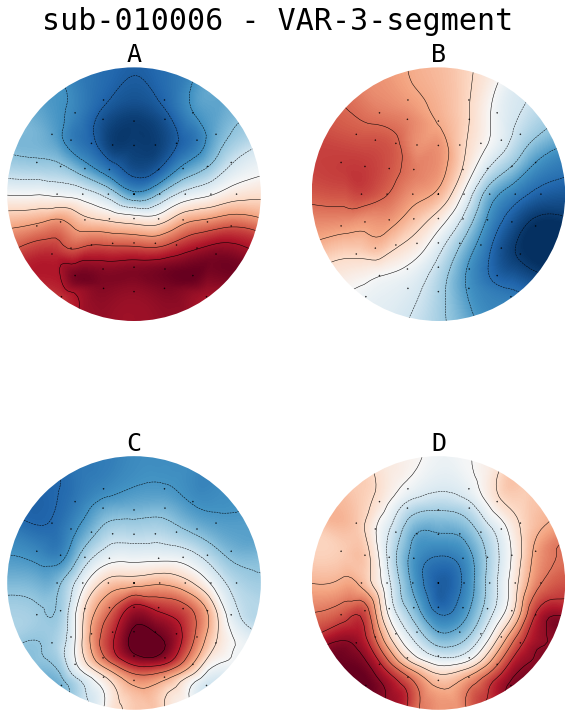

In [5]:
subj_id = "sub-010006"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-3-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
combined = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps_corrs.nc"))
SUBJECTS = list(combined["subj1"].values)

In [7]:
# reflect those matrices
stack_coords = ["latent map", "type1", "type2"]
reflected = []
for coords, dtarray in tqdm(combined.stack(all=stack_coords).groupby("all")):
    refl = np.triu(dtarray, k=1).T + np.nan_to_num(dtarray)
    refl = xr.DataArray(refl, dims=dtarray.dims, coords=dtarray.coords)
    refl = refl.assign_coords({k: v for k, v in zip(stack_coords, coords)}).expand_dims(
        stack_coords
    )
    reflected.append(refl)
reflected = xr.combine_by_coords(reflected).drop_vars("all")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 324/324 [00:00<00:00, 460.12it/s]


In [8]:
var_mean = (
    reflected.isel({"type1": reflected["type1"].str.match("VAR-.*-segment")})
    .sel({"type2": "2nd-segment"})
    .mean("type1")
    .assign_coords({"type1": "VAR-segment-mean"})
    .expand_dims(["type1", "type2"])
)
combined = xr.concat([reflected, var_mean], dim="type1")

In [9]:
combined

<xarray.DataArray (latent map: 4, type1: 10, type2: 9, subj1: 203, subj2: 203)>
array([[[[[1.00000000e+00, 7.76791443e-01, 1.20252238e-01, ...,
           5.17618997e-01, 6.93983149e-01, 7.27402346e-02],
          [7.76791443e-01, 1.00000000e+00, 3.62111990e-01, ...,
           7.12008883e-01, 6.51996535e-01, 3.80554623e-01],
          [1.20252238e-01, 3.62111990e-01, 1.00000000e+00, ...,
           5.08957077e-01, 2.58879927e-01, 8.31060708e-01],
          ...,
          [5.17618997e-01, 7.12008883e-01, 5.08957077e-01, ...,
           1.00000000e+00, 5.40943781e-01, 4.62406922e-01],
          [6.93983149e-01, 6.51996535e-01, 2.58879927e-01, ...,
           5.40943781e-01, 1.00000000e+00, 2.47373163e-01],
          [7.27402346e-02, 3.80554623e-01, 8.31060708e-01, ...,
           4.62406922e-01, 2.47373163e-01, 1.00000000e+00]],

         [[8.70129789e-01, 6.84558045e-01, 1.91363873e-01, ...,
           5.06028431e-01, 6.56661996e-01, 3.81278221e-01],
          [6.84558045e-01, 9.62155513e-01, 4.07913728e-01, ...,
           7.25386103e-01, 6.42663579e-01, 4.42760631e-01],
          [1.91363873e-01, 4.07913728e-01, 9.88135755e-01, ...,
           6.02492444e-01, 2.78151092e-01, 5.74161794e-01],
...
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]],

         [[           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          ...,
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan],
          [           nan,            nan,            nan, ...,
                      nan,            nan,            nan]]]]])
Coordinates:
  * type2       (type2) <U13 '1st-segment' '2nd-segment' ... 'VAR-full'
  * subj1       (subj1) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * subj2       (subj2) object 'sub-010002' 'sub-010003' ... 'sub-010321'
  * latent map  (latent map) <U1 'A' 'B' 'C' 'D'
  * type1       (type1) <U16 '1st-segment' '2nd-segment' ... 'VAR-segment-mean'

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

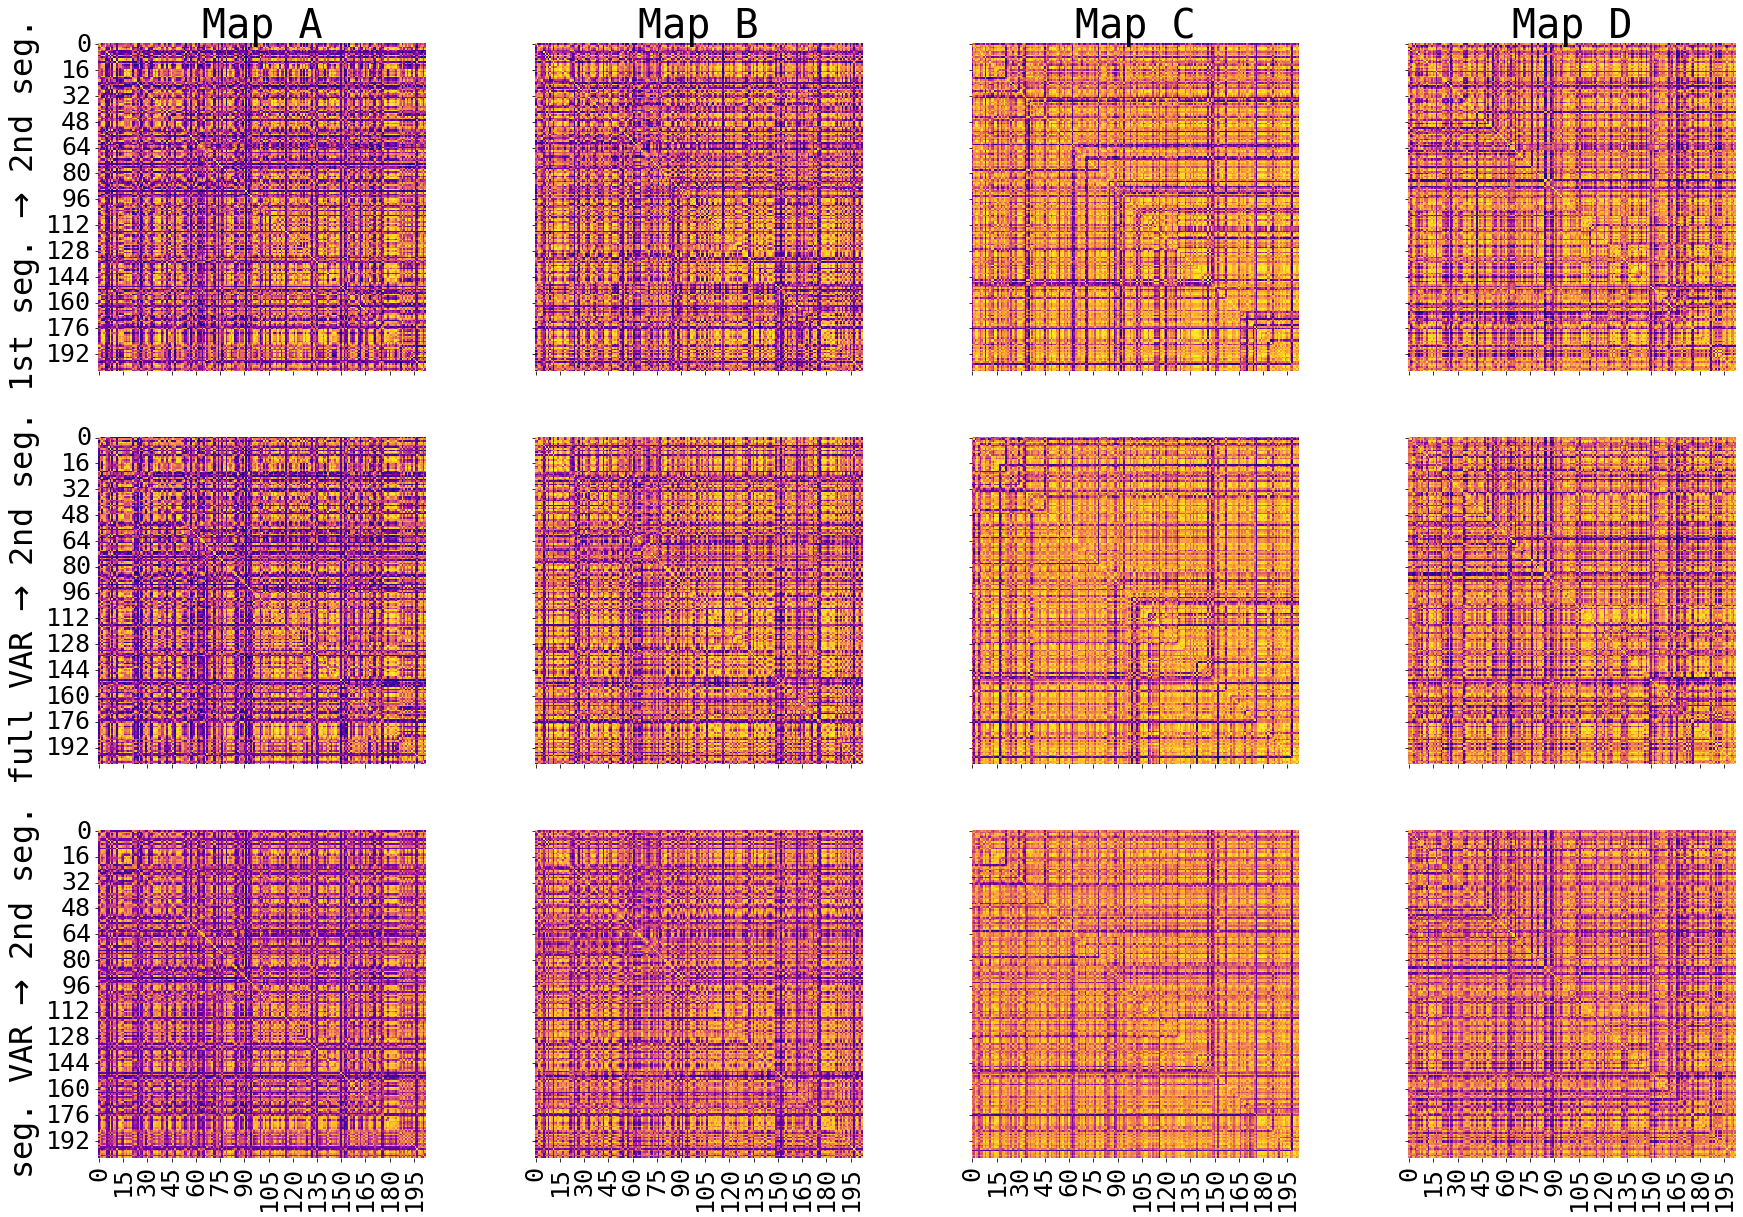

In [10]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

Text(232.07710997442462, 0.5, 'seg. VAR $\\to$ 2nd seg.')

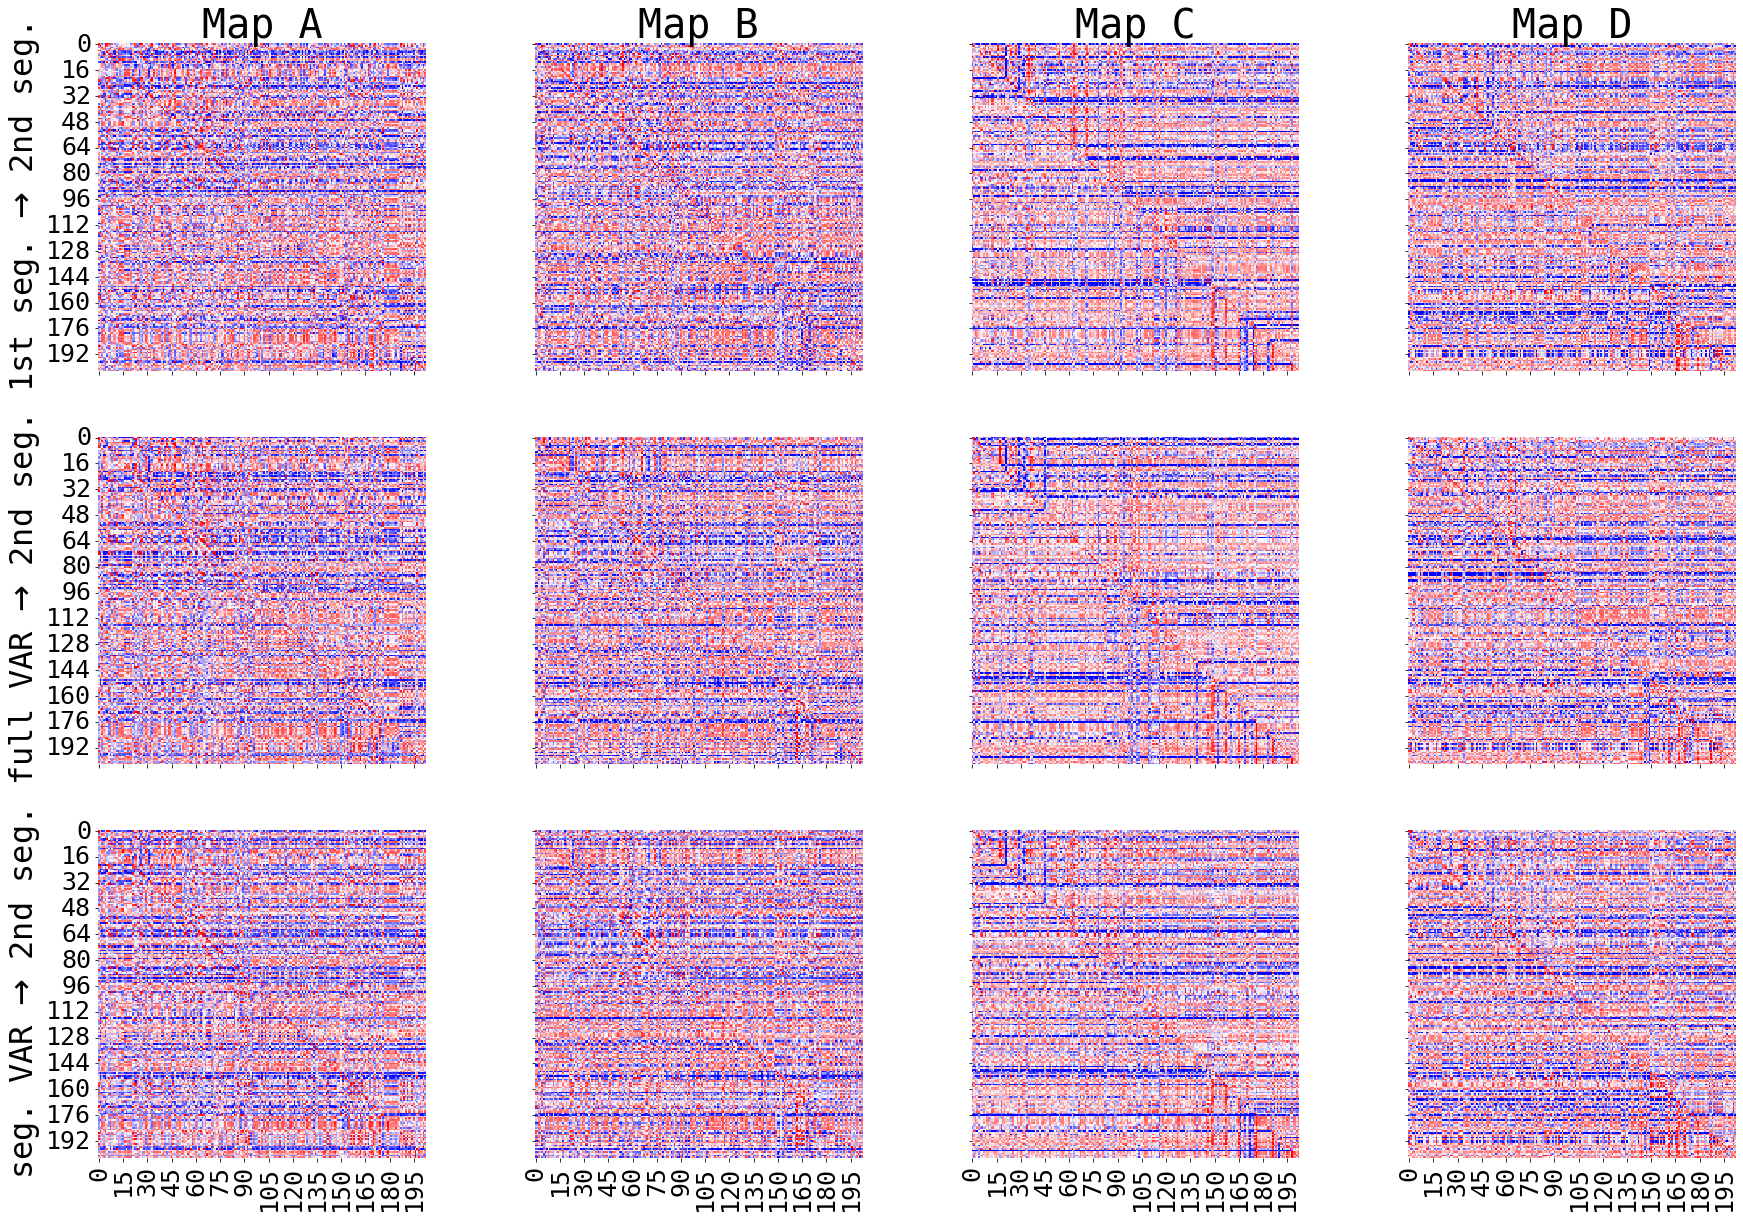

In [11]:
fig, axs = plt.subplots(
    nrows=3, ncols=4, squeeze=True, figsize=(30, 20.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full", "VAR-segment-mean"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")
axs[2, 0].set_ylabel(r"seg. VAR $\to$ 2nd seg.")

In [12]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values),
    index=["1st-segment", "VAR-full", "VAR-segment-mean"],
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full", "VAR-segment-mean"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

A   B   C   D
1st-segment       73  71  68  66
VAR-full          63  60  51  61
VAR-segment-mean  62  58  41  45

A   B   C   D
1st-segment       73  71  68  66
VAR-full          63  60  51  61
VAR-segment-mean  62  58  41  45

# Static and dynamic stats

In [13]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010002 1st-segment       A           0.674959   0.613281       0.959865   
                             B           0.674959   0.613281       0.779983   
                             C           0.674959   0.613281       0.802340   
                             D           0.674959   0.613281       0.821959   
           2nd-segment       A           0.679375   0.622390       0.731083   
...                                           ...        ...            ...   
sub-010319 VAR-segments-mean D           0.758857   0.703148       0.893147   
sub-010321 VAR-segments-mean A           0.851441   0.790432       0.891393   
                             B           0.851441   0.790432       0.791979   
                             C           0.851441   0.790432       0.932104   
                             D           0.851441   0.790432       0.935610   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010002 1st-segment       A           0.245906   17.305171  14.209952   
                             B           0.256283   18.621808  13.762530   
                             C           0.217728   15.516322  14.030791   
                             D           0.280083   19.571787  14.313458   
           2nd-segment       A           0.265172   18.994022  13.960807   
...                                           ...         ...        ...   
sub-010319 VAR-segments-mean D           0.239228   12.710829  18.826161   
sub-010321 VAR-segments-mean A           0.258509   14.781153  17.491259   
                             B           0.216803   14.642267  14.789565   
                             C           0.262646   13.824693  18.981646   
                             D           0.262042   14.128390  18.554284   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010002 1st-segment       A                0.718507       0.087656   
                             B                0.090696       0.709356   
                             C                0.098704       0.084618   
                             D                0.087433       0.123215   
           2nd-segment       A                0.713484       0.106428   
...                                                ...            ...   
sub-010319 VAR-segments-mean D                0.069746       0.069051   
sub-010321 VAR-segments-mean A                0.769165       0.092160   
                             B                0.088702       0.722454   
                             C                0.069949       0.068742   
                             D                0.085081       0.065538   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010002 1st-segment       A                0.084312       0.109525  
                             B                0.086101       0.113847  
                             C                0.714913       0.101766  
                             D                0.068867       0.720486  
           2nd-segment       A                0.087824       0.092265  
...                                                ...            ...  
sub-010319 VAR-segments-mean D                0.073676       0.787527  
sub-010321 VAR-segments-mean A                0.077913       0.060762  
                             B                0.086172       0.102671  
                             C                0.788432       0.072878  
                             D                0.065543       0.783839  

[3248 rows x 10 columns]

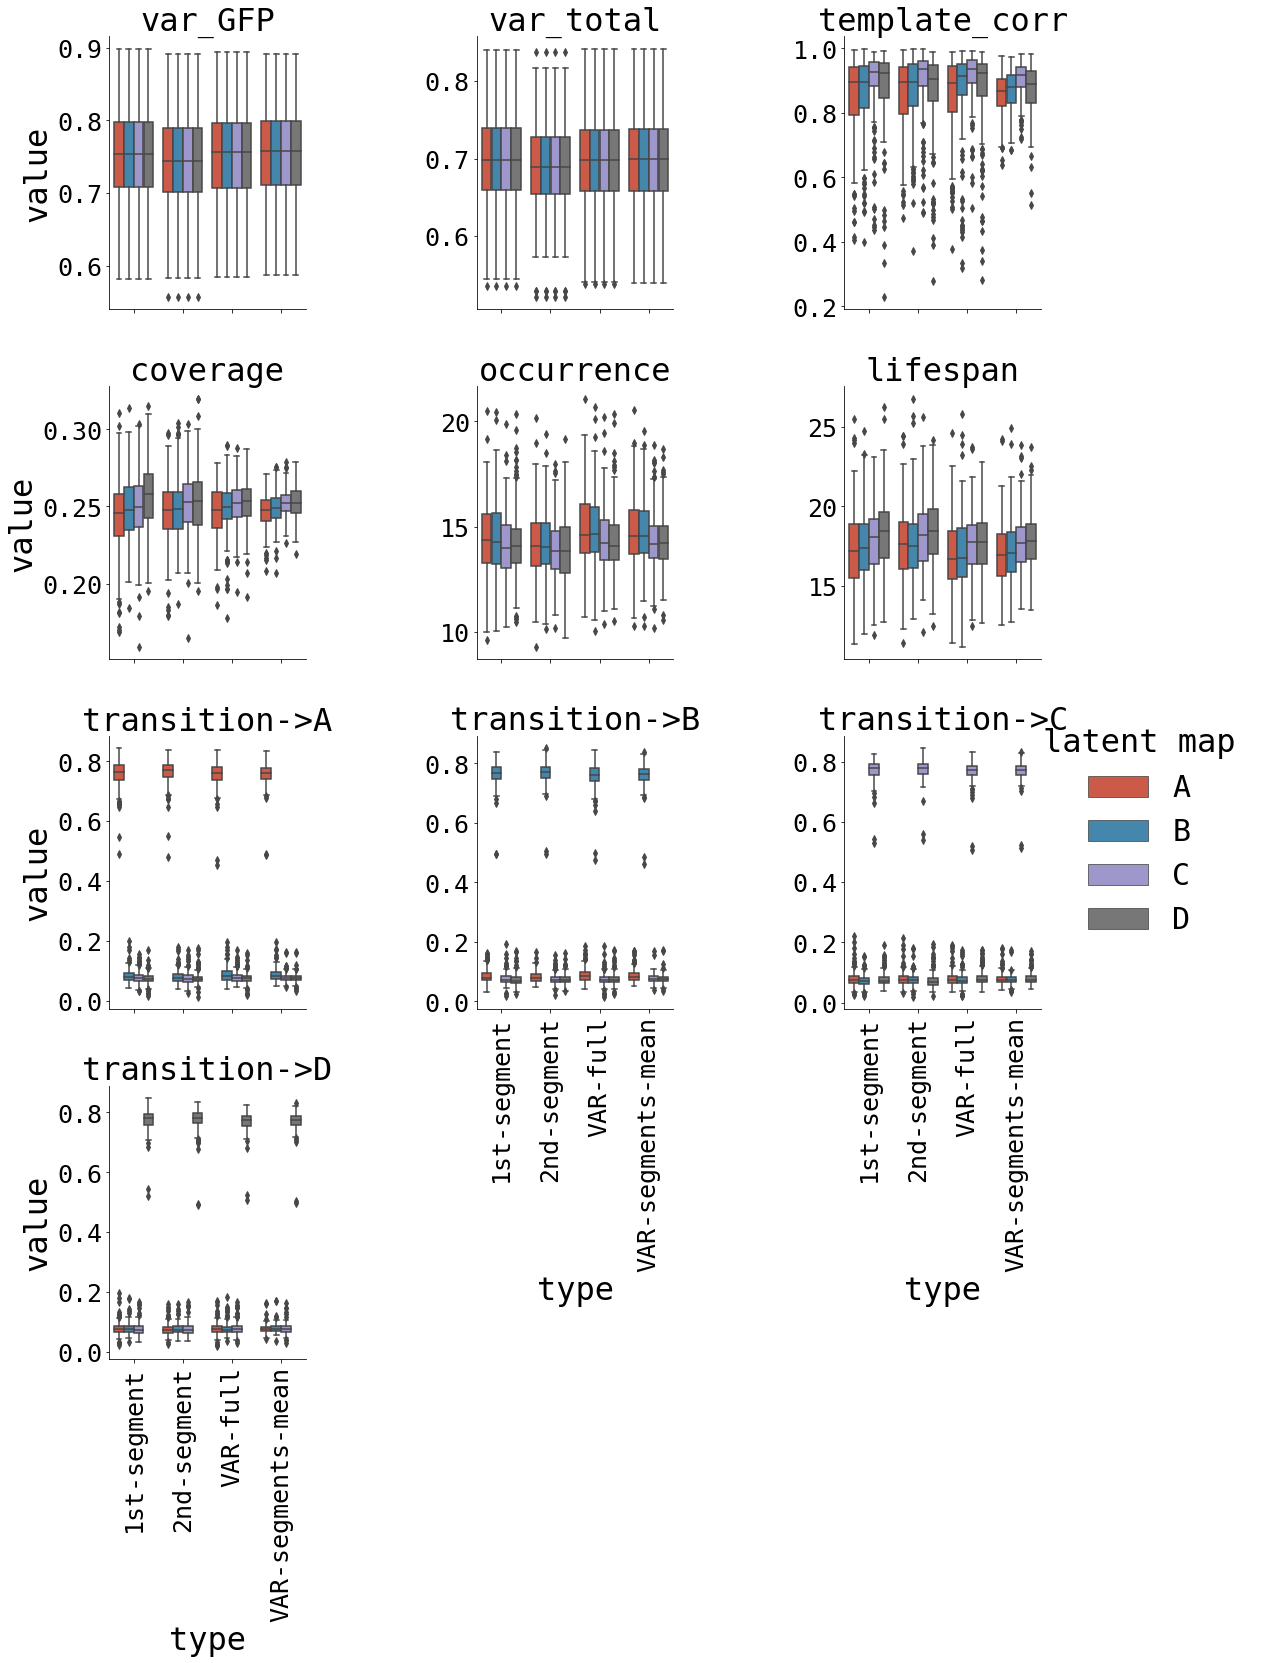

In [14]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
        "transition->A",
        "transition->B",
        "transition->C",
        "transition->D",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [15]:
static_stats_final["template_corr"].groupby(["type", "latent map"]).agg(
    ["mean", "median"]
)

mean    median
type              latent map                    
1st-segment       A           0.851681  0.894591
                  B           0.856714  0.893974
                  C           0.894913  0.926437
                  D           0.880960  0.923220
2nd-segment       A           0.856701  0.895463
                  B           0.869617  0.895553
                  C           0.906628  0.934780
                  D           0.860967  0.906272
VAR-full          A           0.851435  0.893765
                  B           0.875755  0.914604
                  C           0.912726  0.935492
                  D           0.873984  0.922067
VAR-segments-mean A           0.855863  0.866537
                  B           0.868661  0.878629
                  C           0.906052  0.918634
                  D           0.868176  0.887782

In [16]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

df1 = static_stats_final.reset_index()
var_mean_segments = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
static_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [17]:
SIMPLE_MEAN = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
]

TRANS = ["transition->A", "transition->B", "transition->C", "transition->D"]

simple_means = static_diffs.groupby(["subject_id", "diffs"])[SIMPLE_MEAN].mean()
trans_means = (
    static_diffs.groupby(["subject_id", "diffs"])[TRANS]
    .mean()
    .reset_index()
    .melt(id_vars=["subject_id", "diffs"])
    .groupby(["subject_id", "diffs"])["value"]
    .mean()
)
trans_means.name = "transition_matrix"
static_diffs = pd.concat([simple_means, trans_means], axis=1).reset_index()

In [18]:
DVS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition_matrix",
]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(
        pg.pairwise_ttests(
            data=static_diffs,
            dv=dv,
            within="diffs",
            subject="subject_id",
            padjust="fdr_by",
        )
    )

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  5.306069  0.005313  0.000088  0.602128

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0 -5.518282  202.0   two-sided  1.042047e-07  5.731258e-07   fdr_by   
1  0.257867  202.0   two-sided  7.967724e-01  1.000000e+00   fdr_by   
2  2.317086  202.0   two-sided  2.150114e-02  5.912814e-02   fdr_by   

        BF10    hedges  
0  9.414e+04 -0.018758  
1      0.081  0.001955  
2       1.07  0.020681

== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  3.737202  0.024648  0.000032  0.694545

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust     BF10    hedges  
0 -4.316723  202.0   two-sided  0.000025  0.000136   fdr_by  517.033 -0.013180  
1 -0.634525  202.0   two-sided  0.526457  0.965170   fdr_by    0.096 -0.003409  
2  1.599104  202.0   two-sided  0.111361  0.306241   fdr_by    0.275  0.009847

== template_corr ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F         p-unc       ng2       eps
0  diffs      2    404  20.17001  4.472175e-09  0.034772  0.832702

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.735896  202.0   two-sided  1.659683e-10  9.128258e-10   fdr_by   
1  0.642739  202.0   two-sided  5.211224e-01  9.553910e-01   fdr_by   
2 -5.674213  202.0   two-sided  4.786030e-08  1.316158e-07   fdr_by   

        BF10    hedges  
0  4.684e+07  0.451329  
1      0.096  0.049569  
2  1.986e+05 -0.409299

== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  16.985553  8.261388e-08  0.026579  0.731065

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust      BF10  \
0  4.089375  202.0   two-sided  6.243599e-05  1.716990e-04   fdr_by   217.167   
1 -2.629001  202.0   two-sided  9.222226e-03  1.690741e-02   fdr_by     2.239   
2 -5.477665  202.0   two-sided  1.273077e-07  7.001921e-07   fdr_by  7.77e+04   

     hedges  
0  0.217641  
1 -0.195513  
2 -0.395601

== occurrence ==


Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  5.549214  0.004193   0.009025  0.003165  0.749881   

   sphericity   W-spher       p-spher  
0       False  0.666455  1.945075e-18

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust     BF10    hedges  
0  4.597351  202.0   two-sided  0.000008  0.000041   fdr_by  1591.44  0.124826  
1  2.197919  202.0   two-sided  0.029091  0.080001   fdr_by    0.826  0.105204  
2 -0.434003  202.0   two-sided  0.664750  1.000000   fdr_by    0.086 -0.020000

== lifespan ==


Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  9.044828  0.000144   0.000435  0.010622  0.816334   

   sphericity   W-spher       p-spher  
0       False  0.775012  7.507063e-12

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  5.708446  202.0   two-sided  4.026643e-08  2.214654e-07   fdr_by   
1  1.770798  202.0   two-sided  7.810235e-02  1.431876e-01   fdr_by   
2 -2.101273  202.0   two-sided  3.685700e-02  1.013568e-01   fdr_by   

        BF10    hedges  
0  2.344e+05  0.267774  
1      0.364  0.114329  
2      0.676 -0.132868

== transition_matrix ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F     p-unc       ng2       eps
0  diffs      2    404  13.54783  0.000002  0.014395  0.886089

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  6.207874  202.0   two-sided  2.998054e-09  1.648930e-08   fdr_by   
1  1.645611  202.0   two-sided  1.013990e-01  1.858982e-01   fdr_by   
2 -3.252753  202.0   two-sided  1.339537e-03  3.683727e-03   fdr_by   

        BF10    hedges  
0  2.857e+06  0.307936  
1      0.296  0.097044  
2     12.693 -0.194728

In [19]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010002 1st-segment           2.751487  1.994183          2.0   
           2nd-segment           2.717728  1.997192          2.0   
           VAR-full              2.710838  1.996660          2.0   
sub-010003 1st-segment           4.027731  1.978721          2.0   
           2nd-segment           3.707810  1.986801          2.0   
...                                   ...       ...          ...   
sub-010316 VAR-segments-mean     3.680152  1.995107          2.0   
sub-010317 VAR-segments-mean     3.610784  1.997341          2.0   
sub-010318 VAR-segments-mean     3.013769  1.996372          2.0   
sub-010319 VAR-segments-mean     3.645931  1.996201          2.0   
sub-010321 VAR-segments-mean     3.544456  1.987794          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010002 1st-segment            1.261837         1.306045         100.0  
           2nd-segment            1.265721         1.311948          36.0  
           VAR-full               1.286798         1.330976          36.0  
sub-010003 1st-segment            1.000199         1.028645          52.0  
           2nd-segment            1.012374         1.041526          52.0  
...                                    ...              ...           ...  
sub-010316 VAR-segments-mean      1.045921         1.079055          52.0  
sub-010317 VAR-segments-mean      1.082941         1.119538          52.0  
sub-010318 VAR-segments-mean      1.195577         1.245484          44.0  
sub-010319 VAR-segments-mean      1.069252         1.103580          52.0  
sub-010321 VAR-segments-mean      1.097898         1.133398          52.0  

[812 rows x 6 columns]

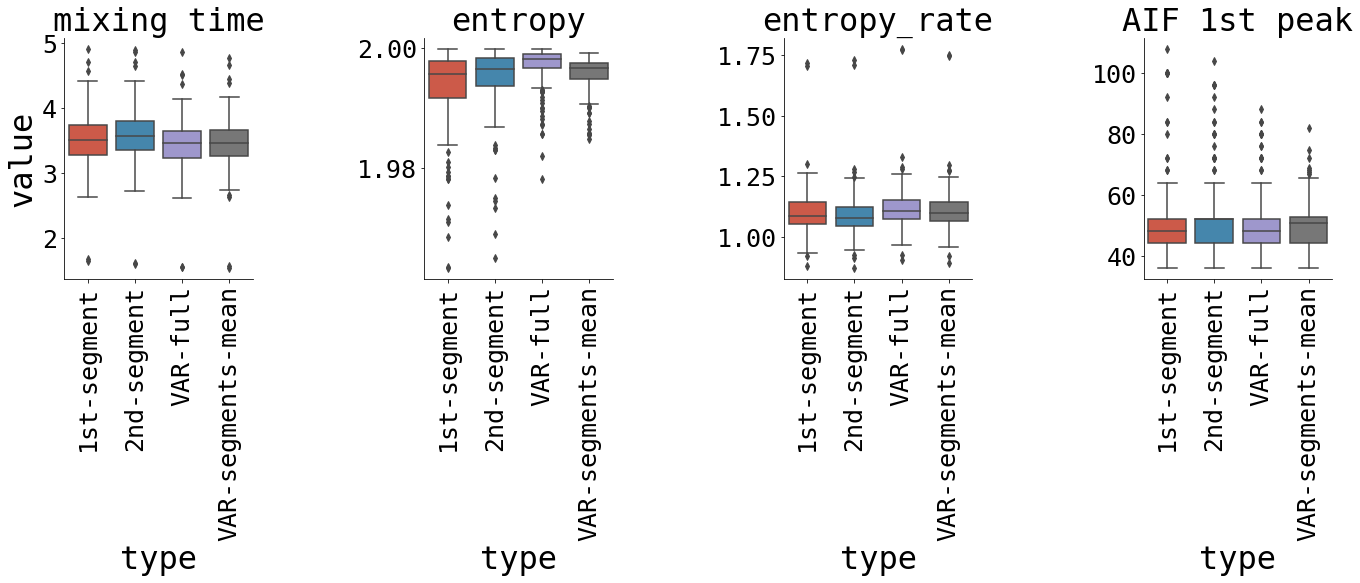

In [20]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [21]:
dynamic_stats

subject_id  mixing time   entropy  max entropy  entropy_rate  \
0   sub-010002     2.751487  1.994183          2.0      1.261837   
0   sub-010002     2.717728  1.997192          2.0      1.265721   
0   sub-010002     2.692133  1.996991          2.0      1.287366   
0   sub-010002     2.645927  1.987891          2.0      1.268483   
0   sub-010002     2.557593  1.990577          2.0      1.283439   
..         ...          ...       ...          ...           ...   
0   sub-010321     3.494931  1.988767          2.0      1.100037   
0   sub-010321     3.558984  1.992814          2.0      1.099591   
0   sub-010321     3.489295  1.992758          2.0      1.090966   
0   sub-010321     3.594492  1.996677          2.0      1.101603   
0   sub-010321     3.565542  1.990023          2.0      1.106493   

    MC entropy rate  AIF 1st peak           type  
0          1.306045         100.0    1st-segment  
0          1.311948          36.0    2nd-segment  
0          1.337380          36.0  VAR-1-segment  
0          1.318429          36.0  VAR-2-segment  
0          1.334491          36.0  VAR-3-segment  
..              ...           ...            ...  
0          1.135536          52.0  VAR-3-segment  
0          1.133912          52.0  VAR-4-segment  
0          1.126486          52.0  VAR-5-segment  
0          1.133824          52.0  VAR-6-segment  
0          1.138215          52.0       VAR-full  

[1827 rows x 8 columns]

In [22]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    ) ** 2
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = all_segments_diffs.reset_index().groupby(["subject_id"]).mean()

df1 = dynamic_stats_final.reset_index()
var_mean_segments = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - df1[df1["type"] == "VAR-segments-mean"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
) ** 2

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_mean_segments["diffs"] = "VAR-segments-mean"
dynamic_diffs = pd.concat(
    [real_data_diff, var_full_diff, var_mean_segments]
).reset_index()

In [23]:
dynamic_diffs

subject_id  mixing time       entropy  entropy_rate  AIF 1st peak  \
0    sub-010002     0.001140  9.054784e-06  1.508262e-05        4096.0   
1    sub-010003     0.102350  6.527834e-05  1.482284e-04           0.0   
2    sub-010004     0.092978  7.037116e-06  1.631540e-03          16.0   
3    sub-010005     0.007550  7.648054e-05  3.836360e-05          16.0   
4    sub-010006     0.003516  1.033947e-06  3.361124e-05          16.0   
..          ...          ...           ...           ...           ...   
604  sub-010316     0.013063  3.907380e-06  2.671508e-04           0.0   
605  sub-010317     0.001756  2.244189e-07  1.139500e-04           0.0   
606  sub-010318     1.560321  7.059797e-06  3.150187e-02        2304.0   
607  sub-010319     0.000690  1.237308e-05  1.054009e-04          16.0   
608  sub-010321     0.000647  4.678846e-06  1.819162e-07           0.0   

                 diffs  
0            real_data  
1            real_data  
2            real_data  
3            real_data  
4            real_data  
..                 ...  
604  VAR-segments-mean  
605  VAR-segments-mean  
606  VAR-segments-mean  
607  VAR-segments-mean  
608  VAR-segments-mean  

[609 rows x 6 columns]

In [24]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(
        pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id")
    )
    display(
        pg.pairwise_ttests(
            data=dynamic_diffs,
            dv=dv,
            within="diffs",
            subject="subject_id",
            padjust="fdr_by",
        )
    )

== mixing time ==


Source  ddof1  ddof2        F     p-unc       ng2       eps
0  diffs      2    404  9.70972  0.000076  0.003699  0.567737

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust    BF10    hedges  
0  3.802207  202.0   two-sided  0.000190  0.001044   fdr_by  76.884  0.047220  
1  3.402169  202.0   two-sided  0.000806  0.002216   fdr_by   20.21  0.150426  
2  2.559620  202.0   two-sided  0.011210  0.020551   fdr_by   1.886  0.102627

== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2         F    p-unc       ng2       eps
0  diffs      2    404  3.737539  0.02464  0.007487  0.707273

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust    BF10    hedges  
0  3.310836  202.0   two-sided  0.001102  0.006060   fdr_by  15.175  0.172603  
1 -0.176527  202.0   two-sided  0.860057  1.000000   fdr_by    0.08 -0.015467  
2 -2.515956  202.0   two-sided  0.012649  0.034786   fdr_by   1.696 -0.221060

== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


Source  ddof1  ddof2          F         p-unc       ng2       eps
0  diffs      2    404  45.445829  1.577570e-18  0.016322  0.537985

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative         p-unc        p-corr p-adjust  \
0  9.683900  202.0   two-sided  1.847715e-18  1.016243e-17   fdr_by   
1  7.204896  202.0   two-sided  1.130446e-11  3.108725e-11   fdr_by   
2  5.512019  202.0   two-sided  1.074795e-07  1.970457e-07   fdr_by   

        BF10    hedges  
0  2.669e+15  0.106222  
1  6.338e+08  0.318580  
2  9.139e+04  0.209830

== AIF 1st peak ==


Source  ddof1  ddof2         F     p-unc  p-GG-corr       ng2       eps  \
0  diffs      2    404  1.017807  0.362311   0.331074  0.001214  0.624449   

   sphericity   W-spher       p-spher  
0       False  0.398589  7.124980e-41

/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


Contrast                  A                  B  Paired  Parametric  \
0    diffs           VAR-full  VAR-segments-mean    True        True   
1    diffs           VAR-full          real_data    True        True   
2    diffs  VAR-segments-mean          real_data    True        True   

          T    dof alternative     p-unc    p-corr p-adjust   BF10    hedges  
0  1.627446  202.0   two-sided  0.105201  0.578607   fdr_by  0.287  0.051356  
1 -0.549966  202.0   two-sided  0.582950  1.000000   fdr_by  0.091 -0.036457  
2 -1.220075  202.0   two-sided  0.223859  0.615612   fdr_by  0.163 -0.082636